# RAG over complex PDF


## Setting
 - Auto Reload
 - path for utils

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [39]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [40]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [41]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [42]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Haiku"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7f70140f04c0>, model_id='anthropic.claude-3-haiku-20240307-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f7014297eb0>])

### Embedding 모델 선택

In [43]:
from langchain.embeddings import BedrockEmbeddings

In [44]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [45]:
import boto3
from utils.ssm import parameter_store

In [46]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [47]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [48]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [49]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: kb_complex_pdf


### OpenSearch Client 생성

In [50]:
from utils.opensearch import opensearch_utils

In [51]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [52]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [53]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document = False, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_pdf=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [54]:
system_prompt = prompt_repo.get_system_prompt()

In [55]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

제공된 재무 상태표에 따르면, 당기손익-공정가치측정유가증권의 구성비는 전년도 4.38%였습니다. 반면에 전년도에는 당기손익인식금융자산이 포함되어 있었으며, 이에 대한 구성비가 0.50%였습니다.
-----------------------------------------------
1. Category: Table, Chunk: 187 Characters
-----------------------------------------------
이 표는 보험회사의 자산, 부채 및 자본 구성을 보여주고 있습니다. 자산 측면에서는 기타포괄손익-공정가치측정유가증권, 대출채권, 당기손익-공정가치측정유가증권 등의 비중이 높습니다.
부채 측면에서는 책임준비금과 특별계정부채가 대부분을 차지하고 있습니다. 전년도와 비교했을 때 자산 및 부채 구성비에 다소 변화가 있었음을 알 수 있습니다.
metadata:
 {'source': './data/complex_pdf/l-test.pdf', 'detection_class_prob': 0.9136442542076111,
'coordinates': {'points': [[237.0698699951172, 424.6722106933594], [237.0698699951172,
1903.337890625], [1519.3260498046875, 1903.337890625], [1519.3260498046875, 424.6722106933594]],
'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}, 'last_modified':
'2024-03-25T04:44:29', 'text_as_html': '<table><thead><th></th><th>금 액</th><th>구 성비</th><th>금
액</th><th>구 성비</th></thead><tr><td></td><td>24,644</td><td>0.93</td><td>25,948</td><td></td></tr><tr


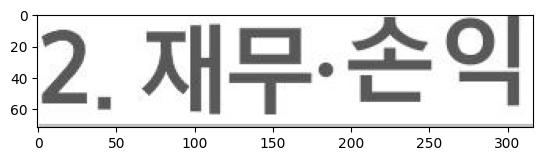

이미지는 한국어로 "2. 재무·손익"이라고 쓰여 있습니다. 이는 아마도 문서나 보고서의 목차 중 하나로, 재무 상황과 손익에 관한 부분을 나타내는 것 같습니다.
metadata:
 {'img_path': './fig/figure-1-1.jpg', 'category': 'Image', 'image_base64': '', 'id':
'f47be48b-9626-4dd7-a5f1-5b65696d0ce3', 'origin_image': ''}

-----------------------------------------------
5. Category: Image, Chunk: 146 Characters
-----------------------------------------------


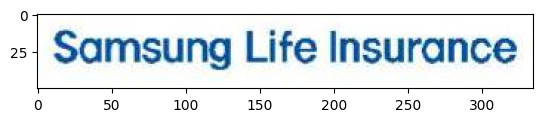

제공된 이미지는 삼성생명보험의 로고입니다. 영문 'Samsung Life Insurance'라는 문구와 함께 청색과 하늘색 계열의 그라데이션 색상으로 구성된 심플한 디자인의
로고입니다. 기업의 브랜드 아이덴티티를 잘 나타내는 직관적이고 모던한 로고 디자인입니다.
metadata:
 {'img_path': './fig/figure-1-2.jpg', 'category': 'Image', 'image_base64': '', 'id':
'4e204d05-faf3-491e-955a-3cd1902bd8ca', 'origin_image': ''}


In [62]:
query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

query = "수익률 그래프 설명해줘"
query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"


query = "대출채권의 전년동기에 해당하는 구성비는 얼마입니까?"

query = "당기손익-공정가치측정유가증권 전년동기의 구성비는?"
response, contexts = qa.invoke(
    query = query
)

show_context_used(contexts)

### Parameter updates

In [57]:
opensearch_hybrid_retriever.update_search_params(
    k=8,
    minimum_should_match=0,
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [58]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

query = "기준 자산가치가 100% 일 때 수익률은?"
query = "수익률 그래프 설명해줘"


[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "contexts": "이미지는 한국어로 \"2. 재무·손익\"이라고 쓰여 있습니다. 이는 아마도 문서나 보고서의 목차 중 하나로, 재무 상황과 손익에 관한 부분을 나타내는 것 같습니다.\n\n부채 및 자본총계 2,655,600 2,777,376 주) 금융감독원 업무보고서 재무제표 기준으로 작성 주) 동 자료는 금융감독원 업무보고서 기준으로 작성되었으며, 감사보고서 상의 공시용 재무제표와 일부 차이가 있을 수 있습니다. 주) 전년동기의 경우, IRFS17/IAS39 기준으로 작성하여 자산’의 구분을 이에 맞게 기재함 ※ 주요 변동요인 회계기준 변경의 효과 → 23.1Q(IFRS17/9기준), 22.1Q(IFRS17/IAS39기준) Samsung Life Insurance 5\n\n2. 재무∙손익 2-2. 요약 재무상태표(총괄) (단위 : 억원, %) 자 산 부채 및 자본 당분기 (2023.3.31) 전년동기 (2022.3.31)\n\n이 표는 보험회사의 자산, 부채 및 자본 구성을 보여주고 있습니다. 자산 측면에서는 기타포괄손익-공정가치측정유가증권, 대출채권, 당기손익-공정가치측정유가증권 등의 비중이 높습니다. 부채 측면에서는 책임준비금과 특별계정부채가 대부분을 차지하고 있습니다. 전년도와 비교했을 때 자산 및 부채 구성비에 다소 변화가 있었음을 알 수 있습니다.\n\n제공된 이미지는 삼성생명보험의 로고입니다. 영문 'Samsung Life Insurance'라는 문구와 함께 청색과 하늘색 계열의 그라데이션 색상으로 구성된 심플한 디자인의 로고입니다. 기업의 브랜드 아이덴티티를 잘 나타내는 직관적이고 모던한 로고 디자인입니다.",
  "tables_text": "구 분 금 액 구성비 금 액 구성비 현금 및 예치금 24,644 0.93 25,948 0.93 당기손익-공정가치측정유가증권 116,339 4.38 0 0.00 당기손익
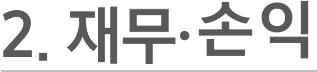
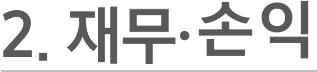

In [59]:
response, contexts = qa.invoke(
    query = query,
    verbose=True
)

In [ ]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)